# Обробка та очищення даних ICESat-2 для побудови профілю рельєфу

## Import libraries

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

## Вхідні дані
- Формат: `.parquet` (дані ICESat-2 ATL03/ATL08)


In [10]:
df = pd.read_parquet(r"C:\Users\user\PycharmProjects\Data_Science_Course_SSWU\task_12\data\atl03x_1_2025-05-07_13_06_41_393.parquet")

# Подивись перші рядки
print(df.head())


                               region  gt  spacecraft_velocity  \
time_ns                                                          
2021-11-26 19:39:20.790408704       6  10          7108.730469   
2021-11-26 19:39:20.795308544       6  10          7108.730469   
2021-11-26 19:39:20.796308480       6  10          7108.730469   
2021-11-26 19:39:20.808008448       6  10          7108.730957   
2021-11-26 19:39:20.808708352       6  10          7108.730957   

                               solar_elevation  longitude  rgt  ph_index  \
time_ns                                                                    
2021-11-26 19:39:20.790408704       -49.910126  24.901195  998     22408   
2021-11-26 19:39:20.795308544       -49.910126  24.901148  998     22419   
2021-11-26 19:39:20.796308480       -49.910126  24.901139  998     22422   
2021-11-26 19:39:20.808008448       -49.910442  24.901029  998     22452   
2021-11-26 19:39:20.808708352       -49.910522  24.901023  998     22454   

    

In [11]:
print(df.columns)


Index(['region', 'gt', 'spacecraft_velocity', 'solar_elevation', 'longitude',
       'rgt', 'ph_index', 'height', 'atl08_class', 'spot', 'x_atc', 'y_atc',
       'cycle', 'atl03_cnf', 'latitude', 'background_rate', 'quality_ph'],
      dtype='object')


  Параметри фільтрації

  - `rgt = 998` — трек
  - `cycle = 1`, `spot = 1` — орбітальні умови
  - `atl08_class == 1` — наземні фотони (ґрунт)
  - `atl03_cnf == 4` — найвища якість фотонів



In [37]:
df_filtered = df[
    (df["rgt"] == 998) &
    (df["cycle"] == 1) &
    (df["spot"] == 1) &
    (df["y_atc"] >= -2641.596) &
    (df["y_atc"] <= -2541.596) &
    df["height"].notna() &
    (df["atl03_cnf"] == 4) &
    df["y_atc"].notna() &
    df["cycle"].notna() &

    df["atl08_class"] == 1
]

print(df_filtered.shape)


(36118, 17)


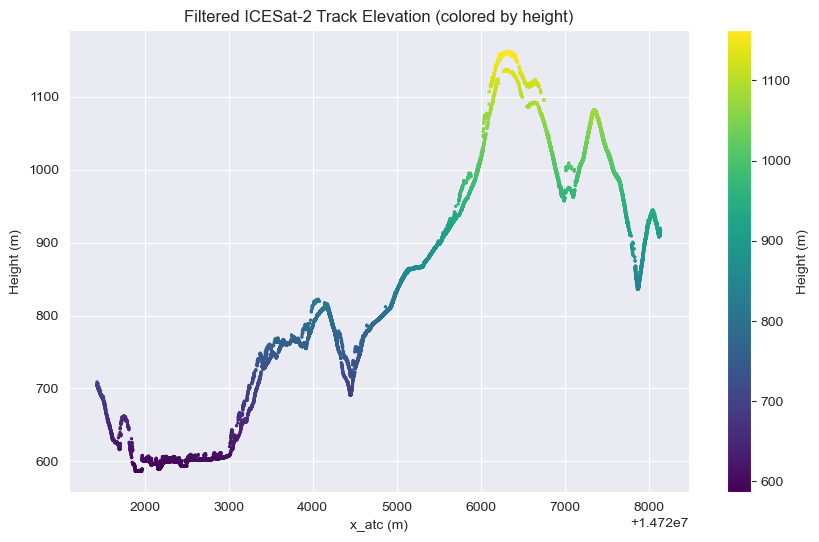

In [38]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(df_filtered["x_atc"], df_filtered["height"], c=df_filtered["height"], cmap="viridis", s=2)
plt.xlabel("x_atc (m)")
plt.ylabel("Height (m)")
plt.colorbar(sc, label="Height (m)")
plt.title("Filtered ICESat-2 Track Elevation (colored by height)")
plt.grid(True)
plt.show()


## Методи очищення ґрунтових точок

### 1. Rolling Minimum + MNK-регресія

* Обчислення ковзного мінімуму.
* Відбір точок біля "дна".
* Поліноміальна регресія та фільтрація за залишками.

 Підходить для базової очистки на однорідних ділянках.



In [14]:
def clean_ground_bottom(df, window=15, tolerance=0.5, degree=3, residual_tol=1.0):
    """
    Очистка ICESat-2 грунтових даних шляхом визначення нижньої частини.

    Параметри:
    - df: pandas DataFrame з колонками 'x_atc', 'height'
    - window: розмір вікна для rolling min
    - tolerance: допустиме відхилення від rolling min
    - degree: порядок полінома для MNK
    - residual_tol: допустиме відхилення від MNK-профілю

    Повертає:
    - df_clean: очищений DataFrame
    """
    df_sorted = df.sort_values("x_atc").copy()

    # Rolling min з вікном
    df_sorted["rolling_min"] = df_sorted["height"].rolling(window=window, center=True).min()

    # Вибираємо точки близькі до "дна"
    df_near_min = df_sorted[
        (df_sorted["height"] - df_sorted["rolling_min"]).abs() < tolerance
    ].copy()

    # MNK: Поліноміальна регресія по x_atc → height
    X = df_near_min["x_atc"].values.reshape(-1, 1)
    y = df_near_min["height"].values
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression().fit(X_poly, y)
    y_pred = model.predict(X_poly)

    # Вираховуємо відхилення від профілю
    residuals = y - y_pred
    df_near_min["residual"] = residuals

    # Залишаємо лише ті точки, що під профілем або дуже близько
    df_clean = df_near_min[df_near_min["residual"] < residual_tol]

    return df_clean


In [15]:
df_ground_cleaned_rolling_min = clean_ground_bottom(df_filtered)


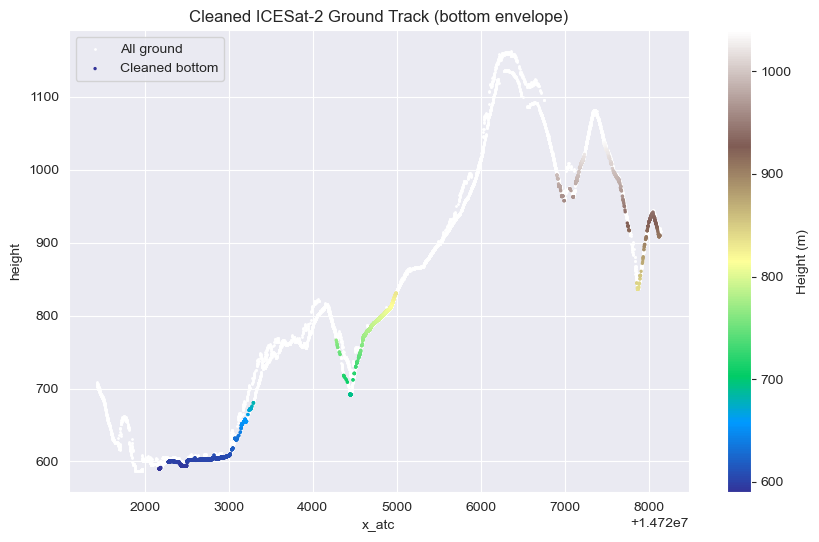

In [16]:

plt.figure(figsize=(10, 6))
plt.scatter(df_filtered["x_atc"], df_filtered["height"], s=1, color="white", label="All ground")
plt.scatter(df_ground_cleaned_rolling_min["x_atc"], df_ground_cleaned_rolling_min["height"], s=2, c=df_ground_cleaned_rolling_min["height"], cmap="terrain", label="Cleaned bottom")
plt.xlabel("x_atc")
plt.ylabel("height")
plt.title("Cleaned ICESat-2 Ground Track (bottom envelope)")
plt.colorbar(label="Height (m)")
plt.legend()
plt.grid(True)
plt.show()



---


### 2. DBSCAN кластеризація

* Виділення кластерів за координатами (`x_atc`, `height`).
* Вибір найнижчих точок у кожному кластері.

Виявляє природні локальні зниження навіть при наявності шуму.


In [17]:
def clean_ground_dbscan(df, eps=10, min_samples=5):
    """
    Кластеризація LiDAR-профілю методом DBSCAN та збереження мінімальної висоти у кожному кластері.

    Параметри:
    - df: DataFrame з колонками x_atc, height
    - eps: радіус для DBSCAN (в метрах)
    - min_samples: мінімальна кількість точок у кластері

    Повертає:
    - df_bottom: тільки найнижчі точки з кожного кластеру
    """
    X = df[["x_atc", "height"]].values

    # DBSCAN кластеризація
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    df = df.copy()
    df["cluster"] = clustering.labels_

    # Видалити шуми (label = -1)
    df = df[df["cluster"] != -1]

    # Залишаємо лише найнижчі точки в кожному кластері
    df_bottom = df.loc[df.groupby("cluster")["height"].idxmin()]

    return df_bottom


In [18]:
df_ground_cleaned_dbscan = clean_ground_dbscan(df_filtered, eps=1.1, min_samples=5)

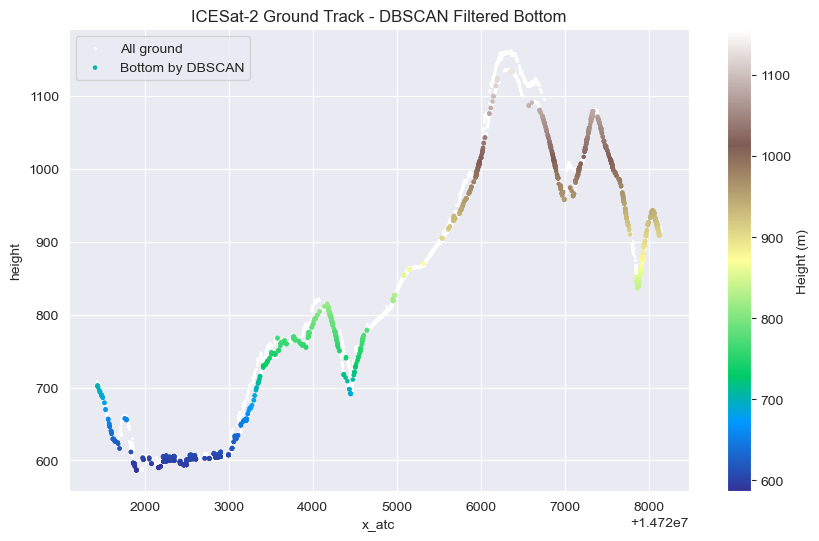

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered["x_atc"], df_filtered["height"], s=1, color="white", label="All ground")
plt.scatter(df_ground_cleaned_dbscan["x_atc"], df_ground_cleaned_dbscan["height"], s=5, c=df_ground_cleaned_dbscan["height"], cmap="terrain", label="Bottom by DBSCAN")
plt.xlabel("x_atc")
plt.ylabel("height")
plt.title("ICESat-2 Ground Track - DBSCAN Filtered Bottom")
plt.colorbar(label="Height (m)")
plt.legend()
plt.grid(True)
plt.show()


---

### 3. Гнучке згладження (rolling + блоки)

* Вибір точок поблизу локального мінімуму.
* Розбиття треку на блоки та фільтрація по щільності.

Дає стабільну смугу ґрунту замість одиничних точок.


In [20]:
def clean_ground_flexible(df, window=15, tolerance=0.8, group_width=10):
    """
    Залишає всі точки у межах певного діапазону від rolling min, зберігаючи “дно” не як одну точку, а як групу.

    - window: ширина rolling-вікна
    - tolerance: висотне відхилення від локального мінімуму
    - group_width: розмір блоку в метрах
    """
    df = df.sort_values("x_atc").copy()
    df["rolling_min"] = df["height"].rolling(window=window, center=True).min()

    # Залишаємо точки в межах допуску від rolling min
    df["is_near_bottom"] = (df["height"] - df["rolling_min"]).abs() < tolerance

    # Групування по x_atc — розбивка на блоки по group_width
    df["block"] = (df["x_atc"] / group_width).astype(int)

    # Зберігаємо лише блоки, де є достатньо точок рельєфу
    kept_blocks = df[df["is_near_bottom"]].groupby("block").filter(lambda g: len(g) >= 2)["block"].unique()

    df_clean = df[df["block"].isin(kept_blocks) & df["is_near_bottom"]]

    return df_clean


In [21]:
df_ground_flexible = clean_ground_flexible(df_filtered, window=15, tolerance=0.8, group_width=30)

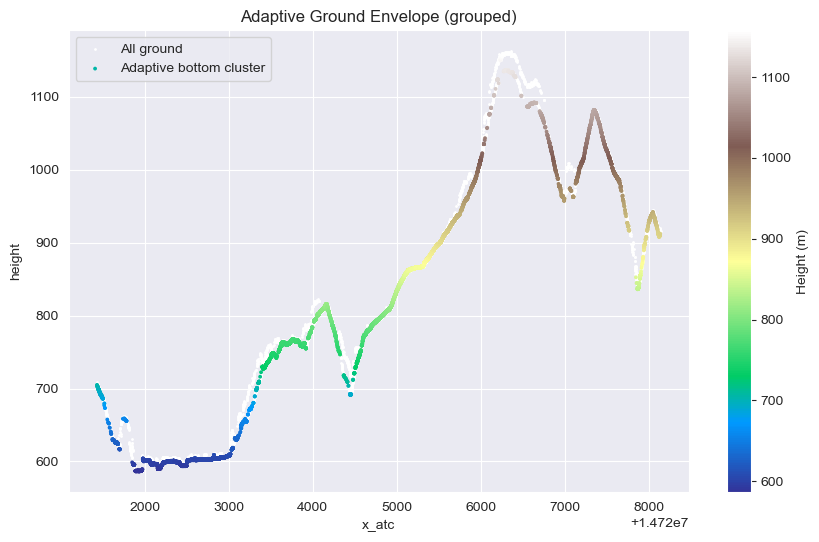

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered["x_atc"], df_filtered["height"], s=1, color="white", label="All ground")
plt.scatter(df_ground_flexible["x_atc"], df_ground_flexible["height"], s=3, c=df_ground_flexible["height"], cmap="terrain", label="Adaptive bottom cluster")
plt.xlabel("x_atc")
plt.ylabel("height")
plt.title("Adaptive Ground Envelope (grouped)")
plt.colorbar(label="Height (m)")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
print("Початково:", df_filtered.shape)
print("Після очищення:", df_ground_flexible.shape)


Початково: (36118, 17)
Після очищення: (25512, 20)


---


### 4. Локальна MNK-регресія (ковзаюче вікно)

* Поліноміальна регресія на кожному сегменті.
* Залишаються лише точки, що лежать під регресійною кривою.

Гнучкий метод, чутливий до вікна.


In [24]:
def clean_ground_mnk_local(df, window_size=150, step=50, degree=2, residual_tol=0.2):
    """
    Локальне очищення ґрунтових точок за допомогою рухомої MNK-регресії.

    - window_size: ширина вікна по x_atc (у метрах)
    - step: крок між вікнами
    - degree: поліноміальний порядок регресії
    - residual_tol: максимальна відстань над моделлю, щоб точку залишити

    Повертає: DataFrame з відфільтрованими точками
    """
    df = df.sort_values("x_atc").copy()
    x = df["x_atc"].values
    result = []

    start = x.min()
    end = x.max()

    for x0 in np.arange(start, end, step):
        x_start = x0
        x_end = x0 + window_size
        df_window = df[(df["x_atc"] >= x_start) & (df["x_atc"] <= x_end)]

        if len(df_window) < degree + 1:
            continue

        # МНК-регресія на локальному вікні
        X = df_window["x_atc"].values.reshape(-1, 1)
        y = df_window["height"].values
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(X)

        model = LinearRegression().fit(X_poly, y)
        y_pred = model.predict(X_poly)
        residuals = y - y_pred

        # Зберігаємо точки, що не перевищують профіль
        df_valid = df_window[residuals <= residual_tol]
        result.append(df_valid)

    if result:
        return pd.concat(result)
    else:
        return pd.DataFrame(columns=df.columns)


In [25]:
df_ground_mnk_local = clean_ground_mnk_local(
    df_filtered, window_size=50, step=15, degree=2, residual_tol=0.7
)


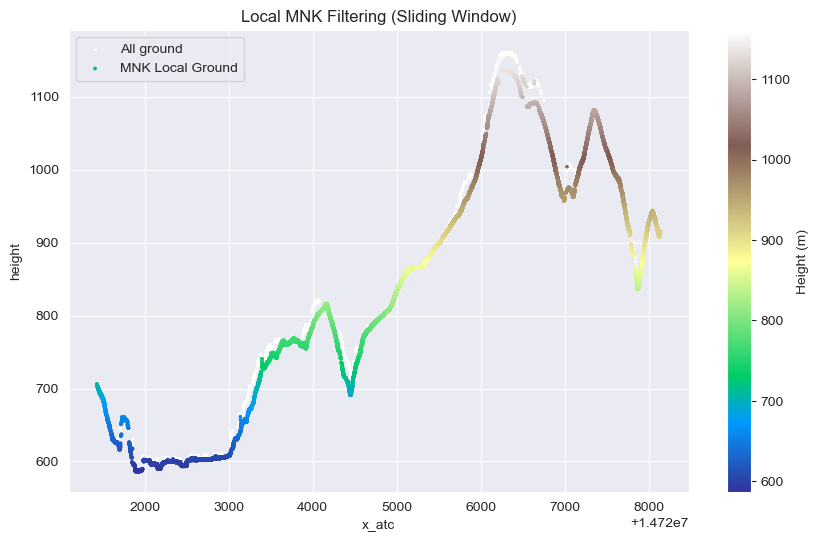

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered["x_atc"], df_filtered["height"], s=1, color="white", label="All ground")
plt.scatter(df_ground_mnk_local["x_atc"], df_ground_mnk_local["height"], s=3, c=df_ground_mnk_local["height"], cmap="terrain", label="MNK Local Ground")
plt.xlabel("x_atc")
plt.ylabel("height")
plt.title("Local MNK Filtering (Sliding Window)")
plt.colorbar(label="Height (m)")
plt.legend()
plt.grid(True)
plt.show()



---


### 5. Покращена локальна MNK з shift_down і tolerance


* Додано вертикальний зсув профілю вниз.

* Гнучке налаштування відхилень зверху/знизу.

Добре працює в складних рельєфних умовах.

In [33]:
def clean_ground_mnk_local_enhanced(df, window_size=150, step=50, degree=2, lower_tol=-0.5, upper_tol=1.0, shift_down=0.3):
    """
    Покращене локальне очищення ґрунтових точок за допомогою рухомої MNK-регресії.
    Замість суворої обрізки, використовує верхню/нижню межу + зміщення вниз.

    - window_size: ширина вікна по x_atc (у метрах)
    - step: крок між вікнами
    - degree: поліноміальний порядок регресії
    - lower_tol: нижня межа залишення точки (відносно моделі)
    - upper_tol: верхня межа залишення точки (відносно моделі)
    - shift_down: вертикальне зміщення моделі вниз для нижнього контуру

    Повертає: DataFrame з відфільтрованими точками
    """
    df = df.sort_values("x_atc").copy()
    x = df["x_atc"].values
    result = []

    start = x.min()
    end = x.max()

    for x0 in np.arange(start, end, step):
        x_start = x0
        x_end = x0 + window_size
        df_window = df[(df["x_atc"] >= x_start) & (df["x_atc"] <= x_end)]

        if len(df_window) < degree + 1:
            continue

        X = df_window["x_atc"].values.reshape(-1, 1)
        y = df_window["height"].values
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(X)

        model = LinearRegression().fit(X_poly, y)
        y_pred = model.predict(X_poly) - shift_down  # зсув моделі вниз
        residuals = y - y_pred

        mask = (residuals >= lower_tol) & (residuals <= upper_tol)
        df_valid = df_window[mask]
        result.append(df_valid)

    if result:
        return pd.concat(result)
    else:
        return pd.DataFrame(columns=df.columns)



In [34]:
df_ground_mnk_local1 = clean_ground_mnk_local_enhanced(df_filtered, window_size=90, step=25, degree=2, lower_tol=-1.0, upper_tol=1.0, shift_down=0.5)

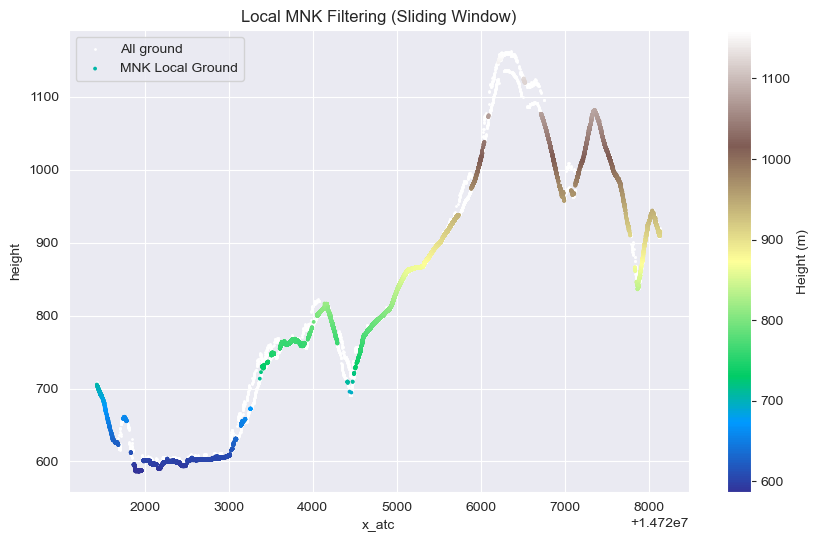

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered["x_atc"], df_filtered["height"], s=1, color="white", label="All ground")
plt.scatter(df_ground_mnk_local1["x_atc"], df_ground_mnk_local1["height"], s=3, c=df_ground_mnk_local1["height"], cmap="terrain", label="MNK Local Ground")
plt.xlabel("x_atc")
plt.ylabel("height")
plt.title("Local MNK Filtering (Sliding Window)")
plt.colorbar(label="Height (m)")
plt.legend()
plt.grid(True)
plt.show()


---

##  Візуалізація

* Створено кілька графіків:

  * Оригінальні точки — білі.
  * Очищені — кольорові (градієнт по висоті).
  * Легенди, підписи, шкала кольору (`colorbar`) додають аналітичну глибину.


## Висновки

* Дані ICESat-2 ATL03/ATL08 можна ефективно обробляти для виділення ґрунтових точок.
* Методи варто адаптувати залежно від мети:

  * **Для точності** — регресійні методи (MNK).
  * **Для стабільності** — DBSCAN, adaptive rolling.
  * **Для складного рельєфу** — покращені локальні MNK.

## Вихідні дані

* Очищені `DataFrame` з нижнім профілем для аналізу DEM.
* Готові до порівняння з цифровими моделями рельєфу (DEM).